In [20]:
import sys
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.io import fits
from astropy.table import Table
from scipy.optimize import curve_fit
from scipy.stats import norm
from matplotlib.pyplot import figure

In [21]:
df = pd.read_csv('Data/Results/targets.csv')
df.head()

,Unnamed: 0,designation,obsid,radial velocity,Equivalent width,Equivalent width uncertainty,reduced chi2
0,0,LAMOST J115502.95+353612.0,821709196,-40.862700,-0.040354,-0.021867,0.409364
1,1,LAMOST J222852.34+262005.4,683603228,41.911037,-0.089436,-0.007120,0.945208
2,2,LAMOST J043456.51+054343.0,885507126,159.302080,-0.051301,-0.030987,0.384847
3,3,LAMOST J055519.53+151909.4,639916124,159.302080,-0.056657,-0.012948,0.644022
4,4,LAMOST J091945.05+295714.1,786008204,35.174934,-0.052827,-0.006079,0.779368


In [22]:
df_grouped = df.groupby('designation').agg({
    'reduced chi2': 'median', 
	'Equivalent width': 'median',
	'Equivalent width uncertainty': 'median',
	'radial velocity': 'median'
}).reset_index()
df_grouped.columns = ['designation', 'radial velocity median','Equivalent width median', 'Equivalent width uncertainty median', 'reduced chi2 median']
df_grouped = df_grouped.loc[df_grouped['Equivalent width median'] != 0]
df_grouped['Equivalent width median log'] = np.log10(np.abs(df_grouped['Equivalent width median']))
df_grouped

,designation,radial velocity median,Equivalent width median,Equivalent width uncertainty median,reduced chi2 median,Equivalent width median log
0,LAMOST J000045.08+062941.8,0.637250,-0.227508,-0.012188,-85.706842,-0.643003
1,LAMOST J000054.12+000557.2,0.745484,-0.151939,-0.035105,62.654655,-0.818329
2,LAMOST J000113.14+363329.4,0.722176,-0.015181,-0.017216,110.900310,-1.818702
3,LAMOST J000153.85+352956.9,1.114205,-0.021600,-0.023445,62.654655,-1.665547
4,LAMOST J000159.70+332027.8,0.984568,-0.070956,-0.022394,28.081955,-1.149014
...,...,...,...,...,...,...
3173,LAMOST J235754.04+083641.0,3.291957,-0.004167,-0.012901,117.970970,-2.380216
3174,LAMOST J235759.43-012526.1,0.510061,-0.059018,-0.015162,62.654655,-1.229017
3175,LAMOST J235823.73+064428.6,0.562229,-0.002003,-0.008816,104.141900,-2.698253
3176,LAMOST J235842.88+080108.3,0.567227,-0.032364,-0.017144,-89.242180,-1.489944


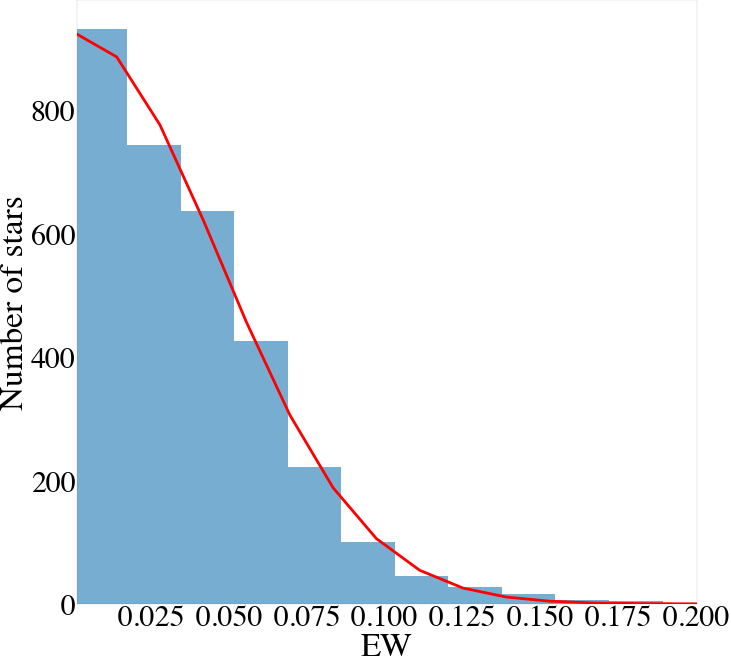

[0.00859616 0.02578771 0.04297926 0.06017081 0.07736236 0.09455391
 0.11174546 0.12893701 0.14612856 0.16332011 0.18051166 0.19770321
 0.21489476 0.23208631 0.24927786 0.26646941 0.28366096 0.30085251
 0.31804406 0.33523561 0.35242716 0.36961871 0.38681026 0.40400181
 0.42119336 0.43838491 0.45557646 0.47276802 0.48995957 0.50715112
 0.52434267 0.54153422 0.55872577 0.57591732 0.59310887 0.61030042
 0.62749197 0.64468352 0.66187507 0.67906662 0.69625817 0.71344972
 0.73064127 0.74783282 0.76502437 0.78221592 0.79940747 0.81659902
 0.83379057 0.85098212 0.86817367 0.88536522 0.90255677 0.91974832
 0.93693987 0.95413142 0.97132298 0.98851453 1.00570608 1.02289763
 1.04008918 1.05728073 1.07447228 1.09166383 1.10885538 1.12604693
 1.14323848 1.16043003 1.17762158 1.19481313 1.21200468 1.22919623
 1.24638778 1.26357933 1.28077088 1.29796243 1.31515398 1.33234553
 1.34953708 1.36672863]


<Figure size 432x288 with 0 Axes>

In [23]:
#plot the distribution and Gaussian fit for the distribution
plt.rcParams.update({'font.family':'times'})
fig= figure(figsize=(100,100),dpi=8)

data = np.absolute(np.array(df_grouped['Equivalent width median']))

# Fix the mean value
fixed_mean = 0

# Define the Gaussian function with the fixed mean
@custom_model
def sum_of_gaussians(x, amplitude=1., mean=-1., sigma=1.):
	return (amplitude * np.exp(-0.5 * ((x - mean) / sigma)**2))

# Calculate the histogram data
counts, bins = np.histogram(data, bins=80, density = False)

# Calculate the bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Fit the Gaussian function to the histogram data
fit = LevMarLSQFitter()
m_init = sum_of_gaussians(amplitude=2000,mean=0, sigma=1)
m_init.mean.fixed = True
m_init.amplitude.fixed = False
m_init.sigma.fixed = False
m = fit(m_init, bin_centers, counts)

# Generate x values for the Gaussian fit line
x = np.linspace(min(data), max(data), 100)

# Plot the histogram
plt.hist(data, bins=80, density=False, alpha=0.6, label='Data')
# Plot the Gaussian fit
plt.plot(x, m(x), 'r', linewidth=25, label='Gaussian fit')
plt.xlabel('EW', size = 300)
plt.ylabel('Number of stars', size = 300)
plt.xticks(fontsize=270)
plt.yticks(fontsize=270)
plt.xlim(0.001, 0.2)
plt.show()
plt.savefig("/Users/mac/Desktop/cassi/Distribution of equivalent width_SDSS.png", dpi=1300, bbox_inches = 'tight')
print(bin_centers)


In [24]:
df_candidates = df_grouped.loc[(df_grouped['Equivalent width median'] < -0.082) & (df_grouped['Equivalent width median']/df_grouped['Equivalent width uncertainty median'] > 3)] 
df_candidates.to_csv('Data/Results/sample_candidates.csv')
df_candidates

,designation,radial velocity median,Equivalent width median,Equivalent width uncertainty median,reduced chi2 median,Equivalent width median log
0,LAMOST J000045.08+062941.8,0.637250,-0.227508,-0.012188,-85.706842,-0.643003
1,LAMOST J000054.12+000557.2,0.745484,-0.151939,-0.035105,62.654655,-0.818329
22,LAMOST J000556.86-012835.5,5.540788,-0.437247,-0.011161,-34.126602,-0.359274
34,LAMOST J000931.30-005813.9,0.441447,-0.140713,-0.038370,124.885510,-0.851667
35,LAMOST J001000.34+082825.2,0.503069,-0.096280,-0.014523,-185.800380,-1.016465
...,...,...,...,...,...,...
3087,LAMOST J225422.45+422750.4,0.584705,-0.127041,-0.040230,-254.722750,-0.896057
3129,LAMOST J233200.69+354135.6,0.483757,-0.150009,-0.031723,-20.141388,-0.823883
3130,LAMOST J233214.61+105620.0,0.857676,-0.096296,-0.014017,131.800050,-1.016392
3142,LAMOST J233901.60+332745.2,0.669999,-0.116676,-0.014156,28.081955,-0.933019


In [25]:
df_candidates[df_candidates["designation"] == 'LAMOST J000556.86-012835.5']

,designation,radial velocity median,Equivalent width median,Equivalent width uncertainty median,reduced chi2 median,Equivalent width median log
22,LAMOST J000556.86-012835.5,5.540788,-0.437247,-0.011161,-34.126602,-0.359274


In [26]:
df[df["designation"] == 'LAMOST J000556.86-012835.5']

,Unnamed: 0,designation,obsid,radial velocity,Equivalent width,Equivalent width uncertainty,reduced chi2
7228,7228,LAMOST J000556.86-012835.5,695904062,-34.126602,-0.437247,-0.011161,5.540788
